# Fraudulent Job Posting Detectors

The following notebook is aimed to create and compare classifier tools to detect fraudulent job postings using only the title, description, and requirement.

## Datasets used

Two datasets are used from Kaggle:
<ol>
    <li> Fake Postings.csv (https://www.kaggle.com/datasets/srisaisuhassanisetty/fake-job-postings)
    <li> data job posts.csv (https://www.kaggle.com/datasets/madhab/jobposts)
    <li> job_train.csv (https://www.kaggle.com/datasets/prxshetty/fake-real-job-listings-dataset)
    <li> (https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction)
</ol>

Dataset #1 has 10,000 rows, all of which are fraudulent.

Dataset #2 has 19,000 rows, all of which are assumed to be legitimate with some NA values. Those with NA in the title/description/requirements are dropped. This resulted in 13,124 rows remaining.

Dataset #3 has 8,940 rows, some of which are legitimate, and some fraudulent.

Dataset #4 has 17,880 rows, some of which are legitimate, and some fraudulent.

In [18]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import StackingClassifier

pd.set_option('display.max_columns', None)

In [3]:
# Step 1: Load the datasets
df1 = pd.read_csv('Fake Postings.csv')
df2 = pd.read_csv('data job posts.csv')
df3 = pd.read_csv('job_train.csv')
df4 = pd.read_csv('fake_job_postings.csv')

In [7]:
df1.head()

,title,description,requirements,company_profile,location,salary_range,employment_type,industry,benefits,fraudulent
0,Mental health nurse,Arm drive court sure vote. Earn $5000/week! Im...,"Basic knowledge in live, no degree required. F...",Rivera and Sons - Established 2022.,West Jeffrey,$55016-$100476,Internship,IT,Free meals,1
1,Conference centre manager,Government whom its bed go tax tree black. Ear...,"Basic knowledge in seek, no degree required. F...","Davidson, Jones and Gomez - Established 2003.",Lake Meredithberg,$53438-$93138,Part-Time,Finance,Flexible hours,1
2,"Engineer, land",I member discuss follow way there nation. Earn...,"Basic knowledge in worker, no degree required....",Allen Ltd - Established 1998.,Lake Cathybury,$45584-$105229,Part-Time,IT,Free travel,1
3,Forest/woodland manager,House across wait approach face. Earn $5000/we...,"Basic knowledge in example, no degree required...",Forbes Ltd - Established 1990.,South Matthewstad,$66188-$139621,Full-Time,Education,Free travel,1
4,"Production designer, theatre/television/film",Case best environmental full finally leader me...,"Basic knowledge in smile, no degree required. ...","Jennings, Martin and Sanchez - Established 1975.",East Rhondafurt,$32183-$115012,Temporary,Retail,Flexible hours,1


In [8]:
df2.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,Location,JobDescription,JobRequirment,RequiredQual,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,"Yerevan, Armenia",AMERIA Investment Consulting Company is seekin...,- Supervises financial management and administ...,"To perform this job successfully, an\r\nindivi...",NaN,"To apply for this position, please submit a\r\...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,"IREX Armenia Main Office; Yerevan, Armenia \r\...",NaN,NaN,- Bachelor's Degree; Master's is preferred;\r\...,NaN,Please submit a cover letter and resume to:\r\...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,"Yerevan, Armenia",Public outreach and strengthening of a growing...,- Working with the Country Director to provide...,"- Degree in environmentally related field, or ...",NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\r\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False
3,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,"Manila, Philippines",The LEAD (Local Enhancement and Development fo...,- Identify gaps in knowledge and overseeing in...,"- Advanced degree in public health, social sci...",NaN,Please send cover letter and resume to Amy\r\n...,NaN,23 January 2004\r\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\r\nJOB TITLE: Software...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,"Yerevan, Armenia",NaN,- Rendering technical assistance to Database M...,- University degree; economical background is ...,NaN,Successful candidates should submit\r\n- CV; \...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [9]:
df3.head()

,title,location,description,requirements,telecommuting,has_company_logo,has_questions,fraudulent
0,Architect (Middleware - MQ) - Kuwait,"KW, KU,","On behalf of our client, a well known multinat...",-Working technical knowledge of IT systems and...,0,1,0,0
1,Interviewing Now for Sales Rep Positions -- wi...,"US, TX, Corpus Christi","We are Argenta Field Solutions, a rapidly expa...",#NAME?,0,1,0,0
2,Process Controls Staff Engineer - Foxboro I/A ...,"US, TX, USA Southwest",Experienced Process Controls Staff Engineer is...,At least 10 years of degreed professional expe...,0,0,0,0
3,Experienced Telemarketer Wanted - Digital Solu...,"AU, NSW,",If you have a passion for people and love to s...,"Responsibilities - Prospecting, following up a...",0,1,0,0
4,Senior Network Engineer,"GB, ENG, London",As the successful Senior Network Engineer you ...,Essential skills:•Juniper switching/routing/se...,0,1,0,0


In [10]:
df4.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [11]:
len(df4)

17880

In [5]:
df1['text'] = df1['title'].fillna('') + ' ' + df1['description'].fillna('') + ' ' + df1['requirements'].fillna('')
df1['fraudulent'] = 1

df2.dropna(subset=['Title', 'JobDescription', 'JobRequirment', 'RequiredQual'], inplace=True)
df2['text'] = (
    df2['Title'].fillna('') + ' ' + df2['JobDescription'].fillna('') + ' ' +
    df2['JobRequirment'].fillna('') + ' ' + df2['RequiredQual'].fillna('')
)
df2['fraudulent'] = 0

df3['title'] = df3['title'].apply(lambda x: x.split('-')[0].strip())
df3['text'] = df3['title'].fillna('') + ' ' + df3['description'].fillna('') + ' ' + df3['requirements'].fillna('')

df4['title'] = df4['title'].apply(lambda x: x.split('-')[0].strip())
df4['text'] = df4['title'].fillna('') + ' ' + df4['description'].fillna('') + ' ' + df4['requirements'].fillna('')

train_df = pd.concat([df1[['text', 'fraudulent']], df2[['text', 'fraudulent']], df3[['text', 'fraudulent']], df4[['text', 'fraudulent']]], ignore_index=True)

In [13]:
len(df1) + len(df3[df3['fraudulent'] == 1]) + len(df4[df4['fraudulent'] == 1])

11322

In [14]:
len(df1) + len(df3[df3['fraudulent'] == 0]) + len(df4[df4['fraudulent'] == 0])

35498

In [6]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(train_df, test_size=0.2, random_state=42)

In [7]:
from imblearn.over_sampling import SMOTE

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data['text']).toarray()
y_train = train_data['fraudulent']

X_test = vectorizer.transform(test_data['text']).toarray()
y_test = test_data['fraudulent']

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [13]:
all_stats_df = pd.DataFrame(columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## K-Nearest Neighbours

In [18]:
knn = KNeighborsClassifier(n_neighbors = 8)
knn.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(n_neighbors=8)

In [19]:
y_pred = knn.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88      7677
           1       0.58      0.99      0.74      2312

    accuracy                           0.83      9989
   macro avg       0.79      0.89      0.81      9989
weighted avg       0.90      0.83      0.85      9989



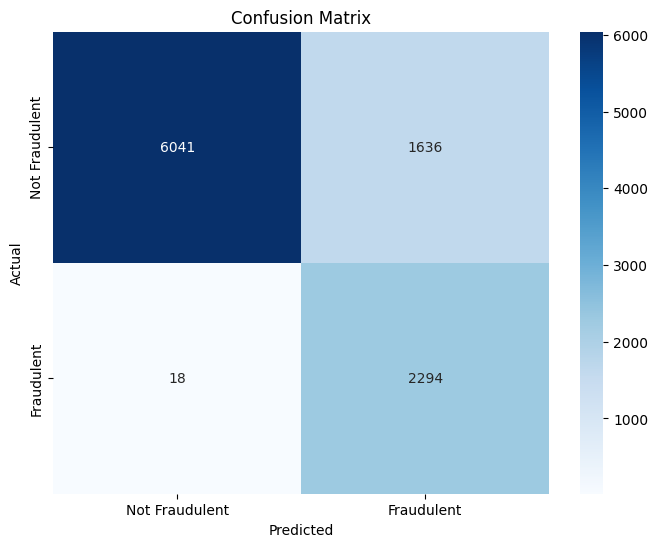

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraudulent', 'Fraudulent'], yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [21]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Create a new DataFrame with the metrics

if 'K-Nearest Neighbours' not in all_stats_df['Classifier'].values:
    new_stats_df = pd.DataFrame([{
        'Classifier': 'K-Nearest Neighbours',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df], ignore_index=True)

all_stats_df

/var/folders/14/9z1c81gx4nz56mqrm1tnqwy80000gn/T/ipykernel_33372/662643007.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stats_df = pd.concat([all_stats_df, new_stats_df], ignore_index=True)


,Classifier,Accuracy,Precision,Recall,F1 Score
0,K-Nearest Neighbours,0.834418,0.583715,0.992215,0.735021


### Result

Accuracy: 83.4%

Precision: 58.4%

Recall: 99.2%

F1-Score: 73.5%

## Logistics Regression

In [22]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7677
           1       0.99      0.95      0.97      2312

    accuracy                           0.99      9989
   macro avg       0.99      0.97      0.98      9989
weighted avg       0.99      0.99      0.99      9989



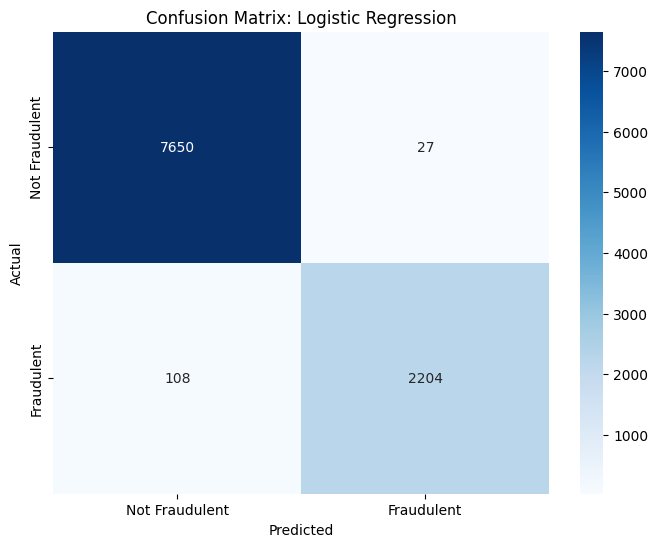

In [23]:
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraudulent', 'Fraudulent'], yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

In [24]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_log_reg)
precision = precision_score(y_test, y_pred_log_reg)
recall = recall_score(y_test, y_pred_log_reg)
f1 = f1_score(y_test, y_pred_log_reg)

# Create a new DataFrame with the metrics

if 'Logistics Regression' not in all_stats_df['Classifier'].values:
    new_stats_df = pd.DataFrame([{
        'Classifier': 'Logistics Regression',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df], ignore_index=True)

all_stats_df

,Classifier,Accuracy,Precision,Recall,F1 Score
0,K-Nearest Neighbours,0.834418,0.583715,0.992215,0.735021
1,Logistics Regression,0.986485,0.987898,0.953287,0.970284


### Result

Accuracy: 98.6%

Precision: 98.8%

Recall: 95.3%

F1-Score: 97.0%

## Support Vector Machine + PCA

From Trial and Error, SVM alone takes a long time to run. Hence, PCA will also be used to reduce complexity.

In [9]:
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_resampled)
X_test_pca = pca.transform(X_test)
sum(list(pca.explained_variance_ratio_))

0.36817369328287763

In [10]:
svm = SVC(random_state=42, kernel='linear')
svm.fit(X_train_pca, y_train_resampled)
y_pred_svm = svm.predict(X_test_pca)
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      7677
           1       0.98      0.93      0.95      2312

    accuracy                           0.98      9989
   macro avg       0.98      0.96      0.97      9989
weighted avg       0.98      0.98      0.98      9989



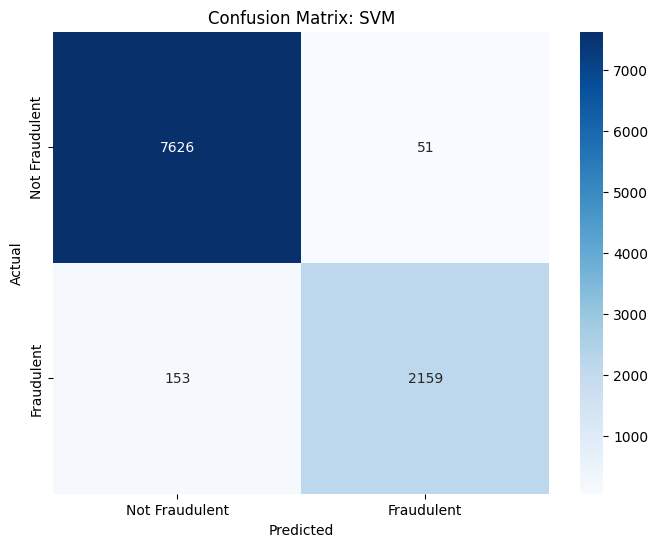

In [11]:
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraudulent', 'Fraudulent'], yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: SVM')
plt.show()

In [19]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

# Create a new DataFrame with the metrics

if 'Support Vector Machine' not in all_stats_df['Classifier'].values:
    new_stats_df = pd.DataFrame([{
        'Classifier': 'Support Vector Machine',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df], ignore_index=True)

all_stats_df

/var/folders/14/9z1c81gx4nz56mqrm1tnqwy80000gn/T/ipykernel_1415/1150740544.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stats_df = pd.concat([all_stats_df, new_stats_df], ignore_index=True)


,Classifier,Accuracy,Precision,Recall,F1 Score
0,Support Vector Machine,0.979578,0.976923,0.933824,0.954887


### Result

Accuracy: 98.0%

Precision: 97.7%

Recall: 93.4%

F1-Score: 95.5%

## Decision Tree

To be continued...

In [20]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train_resampled, y_train_resampled)
y_pred_tree = tree.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_tree))

KeyboardInterrupt: 

In [ ]:
conf_matrix_tree = confusion_matrix(y_test, y_pred_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_tree, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraudulent', 'Fraudulent'], yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Decision Tree')
plt.show()

In [16]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)

# Create a new DataFrame with the metrics

if 'Decision Tree' not in all_stats_df['Classifier'].values:
    new_stats_df = pd.DataFrame([{
        'Classifier': 'Decision Tree',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df], ignore_index=True)

all_stats_df

NameError: name 'accuracy_score' is not defined

### Result


Accuracy: --%

Precision: --%

Recall: --%

F1-Score: --%

## Ensemble Learning

Stacking Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7677
           1       0.88      0.94      0.91      2312

    accuracy                           0.96      9989
   macro avg       0.93      0.95      0.94      9989
weighted avg       0.96      0.96      0.96      9989



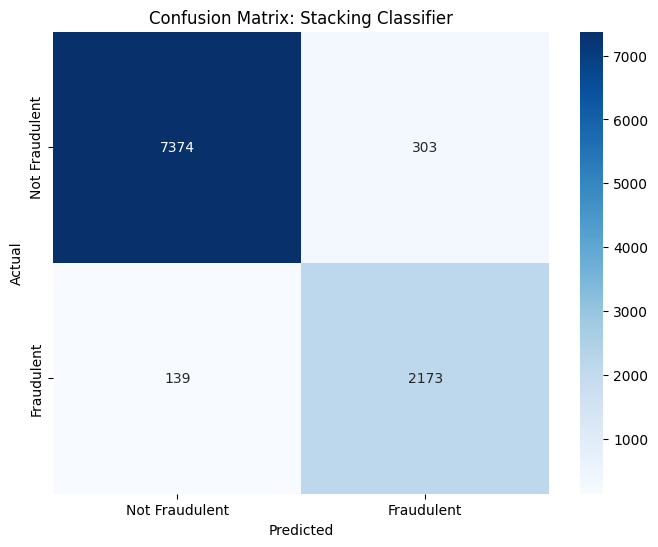

,Classifier,Accuracy,Precision,Recall,F1 Score
0,Support Vector Machine,0.979578,0.976923,0.933824,0.954887
1,Stacking Classifier,0.955751,0.877625,0.939879,0.907686


In [21]:
# Define base classifiers
base_classifiers = [
    ('svm', SVC(kernel='linear', random_state=42)),
    ('log_reg', LogisticRegression(random_state=42))
]

# Define the stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_classifiers,
    final_estimator=DecisionTreeClassifier(random_state=42),
    cv=5
)

# Fit the stacking classifier on the resampled training data
stacking_clf.fit(X_train_pca, y_train_resampled)

# Predict on the test data
y_pred_stacking = stacking_clf.predict(X_test_pca)

# Print classification report
print("Stacking Classifier Classification Report:")
print(classification_report(y_test, y_pred_stacking))

In [ ]:
conf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_stacking, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraudulent', 'Fraudulent'], yticklabels=['Not Fraudulent', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Stacking Classifier')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred_stacking)
precision = precision_score(y_test, y_pred_stacking)
recall = recall_score(y_test, y_pred_stacking)
f1 = f1_score(y_test, y_pred_stacking)

# Create a new DataFrame with the metrics
if 'Stacking Classifier' not in all_stats_df['Classifier'].values:
    new_stats_df = pd.DataFrame([{
        'Classifier': 'Stacking Classifier',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }])

    all_stats_df = pd.concat([all_stats_df, new_stats_df], ignore_index=True)

all_stats_df